In [25]:
import os
# torch
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import functional as F
from torch import optim

# torchvision
import torchvision
from torchvision import transforms

In [26]:
import numpy as np
import matplotlib.pyplot as plt

In [27]:
# Preset parameters
BATCH_SIZE = 64
learning_rate = 1e-1
keep_prob = 0.7

In [28]:
# Load datasets
# tf = transforms.Compose([transforms.ToTensor(), transforms.Resize((64,64))])  # 转为张量数据，同时resize为64*64
tf = transforms.Compose([transforms.ToTensor(), transforms.Resize([28, 28])])  # 转为张量数据，同时resize为28*28
db = torchvision.datasets.ImageFolder(root = 'data', transform = tf) 

In [29]:
# Chekc info
db

Dataset ImageFolder
    Number of datapoints: 27558
    Root location: data
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=[28, 28], interpolation=bilinear, max_size=None, antialias=None)
           )

In [30]:
# ### Spliting
# unsplit_data, test_data = torch.utils.data.random_split(db, [19290, 8268])
# train_data, val_data = torch.utils.data.random_split(unsplit_data, [12860, 6430])

# # Retrieving
# train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = BATCH_SIZE, shuffle = True)
# validation_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size = BATCH_SIZE, shuffle = False)
# test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = BATCH_SIZE, shuffle = False)

In [31]:
### Stratified spliting
from sklearn.model_selection import train_test_split

In [32]:
targets = db.targets

train_idx, test_idx= train_test_split(np.arange(len(targets)), train_size=(0.7*2/3), test_size=0.3, shuffle=True, stratify=targets)
validate_idx = np.setdiff1d(np.arange(len(targets)), np.union1d(train_idx, test_idx))

# train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
# validate_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
# test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

train_data = torch.utils.data.Subset(db, train_idx)
test_data = torch.utils.data.Subset(db, test_idx)
validate_data = torch.utils.data.Subset(db, validate_idx)

In [33]:
tt = len(train_idx) + len(validate_idx) + len(test_idx)

print(f'''The train dataset: {len(train_idx)},{len(train_idx)/tt:.2f}
The validate dataset: {len(validate_idx)}, {len(validate_idx)/tt:.2f}
The test dataset: {len(test_idx)}, {len(test_idx)/tt:.2f}
total length: {tt}''')

The train dataset: 12860,0.47
The validate dataset: 6430, 0.23
The test dataset: 8268, 0.30
total length: 27558


In [34]:
# 验证拆分结果
len(np.setdiff1d(np.arange(len(targets)), np.union1d(train_idx, test_idx)))

6430

In [35]:
# 验证拆分结果
np.intersect1d(train_idx, test_idx)

array([], dtype=int32)

In [36]:
# train_loader = torch.utils.data.DataLoader(db, batch_size=BATCH_SIZE, sampler=train_sampler)
# validate_loader = torch.utils.data.DataLoader(db, batch_size=BATCH_SIZE, sampler=validate_sampler)
# test_loader = torch.utils.data.DataLoader(db, batch_size=BATCH_SIZE, sampler=test_sampler)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE)
validate_loader = torch.utils.data.DataLoader(validate_data, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [37]:
len(db.targets)

27558

In [38]:
len(train_loader.dataset)

12860

In [39]:
# LeNet5
class LeNet5(nn.Module):
    
    def __init__(self):
        super(LeNet5, self).__init__() # 超继承
        self.model = nn.Sequential(
        # 第一个卷积层
        nn.Conv2d(3, 6, kernel_size=3, stride=1),
        # 高宽各减半的池化层
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        # 第二个卷积层
        nn.Conv2d(6, 16, kernel_size=3, stride=1),
        # 高宽各减半的池化层
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        
        # 展开
        nn.Flatten(),
        # MLP
        nn.Linear(400, 120, bias=True),
        nn.ReLU(),
        nn.Linear(120, 84, bias=True),
        nn.ReLU(),
        nn.Dropout(keep_prob),
        nn.Linear(84, 2),
        )
    def forward(self, x):
        x = self.model(x)
        x_softmax = F.softmax(x, dim=1)
        return x_softmax

In [40]:
model = LeNet5()

In [41]:
#  optimizer & loss function
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
loss_function = nn.CrossEntropyLoss()

In [42]:
def train(
    model,
    data_loader,
    optimizer,
    loss_function,
    epoch,
    log_interval=200    # print out info every 200 batches
):
    model.train()
    for batch_idx, (x, label) in enumerate(data_loader):
        
        optimizer.zero_grad()
        output = model(x)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx*len(x), len(data_loader.dataset),
                100. * batch_idx/len(data_loader), loss.data.item()
                # "batch_idx/len(data_loader)" = 当前的batch index除以batch总数
            ))

In [43]:
def validate(
    model, 
    data_loader,
    loss_function,
    epoch,
    loss_vector,
    accuracy_vector
):
    '''applied at train dataset as well as validate dataset'''
    model.eval()
    loss, correct = 0, 0
    for x, label in data_loader: # retrieve tensor dataset and label
        output = model(x)
        loss += loss_function(output, label).data.item()   # "loss_function" is pre-defined, which should be applied in this section
        pred = output.data.max(1)[1]
        correct += pred.eq(label.data).cpu().sum()
    
    # save cal
    loss /= len(data_loader)
#     print(data_loader.dataset)
    loss_vector.append(loss) # for plotting
    accuracy = 100. * correct.to(torch.float32) / len(data_loader.dataset)
    accuracy_vector.append(accuracy)
    print('Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        loss, correct, len(data_loader.dataset), accuracy
    ))

In [44]:
def main(model, train_loader, validate_loader, optimizer, loss_function, num_epochs):
    lossv, accv = [], []
    train_lossv, train_accv = [], []
    for epoch in range(1, num_epochs+1):
        train(model, train_loader, optimizer, loss_function, epoch)
        print("Train set:")
        validate(model, train_loader, loss_function, epoch, train_lossv, train_accv)
        print("Validate set:")
        validate(model, validate_loader, loss_function, epoch, lossv, accv)
    return {'validate':[lossv, accv], 'train':[train_lossv, train_accv]}

In [45]:
info_dict = main(model, train_loader, validate_loader, optimizer, loss_function, 50)

Train Epoch: 1 [0/12860 (0%)]	Loss: 0.689810
Train Epoch: 1 [12000/12860 (100%)]	Loss: 0.702367
Train set:
Average loss: 0.6897, Accuracy: 6430/12860 (50%)

Validate set:
Average loss: 0.6903, Accuracy: 3215/6430 (50%)

Train Epoch: 2 [0/12860 (0%)]	Loss: 0.690371
Train Epoch: 2 [12000/12860 (100%)]	Loss: 0.629691
Train set:
Average loss: 0.6046, Accuracy: 8991/12860 (70%)

Validate set:
Average loss: 0.6077, Accuracy: 4462/6430 (69%)

Train Epoch: 3 [0/12860 (0%)]	Loss: 0.630547
Train Epoch: 3 [12000/12860 (100%)]	Loss: 0.638471
Train set:
Average loss: 0.6391, Accuracy: 8401/12860 (65%)

Validate set:
Average loss: 0.6411, Accuracy: 4155/6430 (65%)

Train Epoch: 4 [0/12860 (0%)]	Loss: 0.648056
Train Epoch: 4 [12000/12860 (100%)]	Loss: 0.523602
Train set:
Average loss: 0.5292, Accuracy: 9999/12860 (78%)

Validate set:
Average loss: 0.5363, Accuracy: 4935/6430 (77%)

Train Epoch: 5 [0/12860 (0%)]	Loss: 0.582949
Train Epoch: 5 [12000/12860 (100%)]	Loss: 0.468740
Train set:
Average loss:

Train Epoch: 38 [12000/12860 (100%)]	Loss: 0.929928
Train set:
Average loss: 0.8133, Accuracy: 6430/12860 (50%)

Validate set:
Average loss: 0.8159, Accuracy: 3215/6430 (50%)

Train Epoch: 39 [0/12860 (0%)]	Loss: 0.750762
Train Epoch: 39 [12000/12860 (100%)]	Loss: 0.929928
Train set:
Average loss: 0.8133, Accuracy: 6430/12860 (50%)

Validate set:
Average loss: 0.8159, Accuracy: 3215/6430 (50%)

Train Epoch: 40 [0/12860 (0%)]	Loss: 0.750762
Train Epoch: 40 [12000/12860 (100%)]	Loss: 0.929928
Train set:
Average loss: 0.8133, Accuracy: 6430/12860 (50%)

Validate set:
Average loss: 0.8159, Accuracy: 3215/6430 (50%)

Train Epoch: 41 [0/12860 (0%)]	Loss: 0.750762
Train Epoch: 41 [12000/12860 (100%)]	Loss: 0.929928
Train set:
Average loss: 0.8133, Accuracy: 6430/12860 (50%)

Validate set:
Average loss: 0.8159, Accuracy: 3215/6430 (50%)

Train Epoch: 42 [0/12860 (0%)]	Loss: 0.750762
Train Epoch: 42 [12000/12860 (100%)]	Loss: 0.929928
Train set:
Average loss: 0.8133, Accuracy: 6430/12860 (50%)


In [23]:
from matplotlib import font_manager

config = {
    "font.family":'Times New Roman', # sans-serif/serif/cursive/fantasy/monospace
    "font.size": 15, # medium/large/small
    'font.style':'normal', # normal/italic/oblique
    'font.weight':'normal', # bold
    "mathtext.fontset":'cm',# 'cm' (Computer Modern)
    "font.serif": ['cmb10'], # 'Simsun'宋体
    "axes.unicode_minus": False,# 用来正常显示负号
}

# plot
def EA_curve(train_loss_vector, validate_loss_vector, train_acc_vector, validate_acc_vector, num_epochs):
    plt.figure(figsize=(5, 3))
    plt.rcParams.update(config)
    plt.plot(np.arange(1, num_epochs+1), train_loss_vector, label="Train error", color='r')
    plt.plot(np.arange(1, num_epochs+1), validate_loss_vector, label="Validation error", color='blue')
    plt.title("Error")
    plt.legend(loc="best")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    
    plt.figure(figsize=(5,3))
    plt.plot(np.arange(1,num_epochs+1), train_acc_vector,label="Train accuracy", color='r')
    plt.plot(np.arange(1,num_epochs+1), validate_acc_vector,label="Validation accuracy", color='blue')
    plt.title('Accuracy')
    plt.legend(loc = "best")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

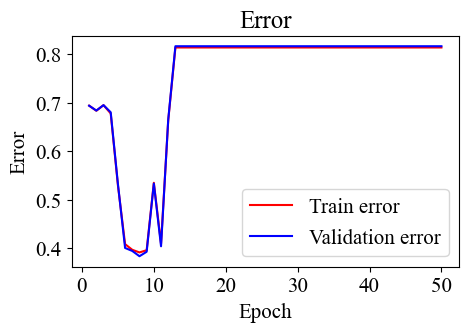

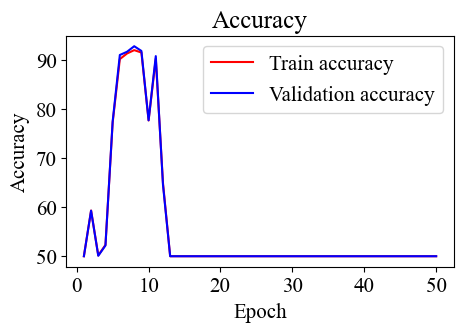

In [24]:
EA_curve(info_dict['train'][0], info_dict['validate'][0], info_dict['train'][1], info_dict['validate'][1], 50)

In [86]:
# accuracy calculation
# !!! it requires the input object still possessing the "data" and "targets" attributes
def accuracyCal(model, test_data):
    model.eval()
    output = model(test_data.data/255)
    pred = output.data.max(1)[1]
    accuracy = pred.eq(test_data.targets).cpu().sum().to(torch.float32) / len(test_data)
    print(accuracy)

In [87]:
# type(test_data)
# accuracyCal(model, test_data)

In [88]:
# accuracy calculation
model.eval()
correct = 0
total = 0
for images, labels in test_loader:
    images = images.float()
    outputs = model(images).cpu()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy：%.2f%%' % (100 * correct / total))

Accuracy：95.51%


In [40]:
### Test
# accuracy calculation
model.eval()
correct = 0
total = 0
for images, labels in test_loader:
    images = images.float()
    outputs = model_re(images).cpu()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy：%.2f%%' % (100 * correct / total))

Accuracy：50.00%


In [28]:
# Save trained model
# torch.save(model.state_dict(), 'results/LeNet5-cellimage.pkl')
# torch.save(model, 'results/LeNet5-cellimage.pkl')
model_re = torch.load('results/LeNet5-cellimage.pkl')

In [22]:
# Test
from matplotlib import font_manager

config = {
    "font.family":'Times New Roman', # sans-serif/serif/cursive/fantasy/monospace
    "font.size": 20, # medium/large/small
    'font.style':'normal', # normal/italic/oblique
    'font.weight':'normal', # bold
    "mathtext.fontset":'cm',# 'cm' (Computer Modern)
    "font.serif": ['cmb10'], # 'Simsun'宋体
    "axes.unicode_minus": False,# 用来正常显示负号
}


to_pil_image = transforms.ToPILImage()

i = 0
for image, label in train_loader:
    i+=1
    # 方法2：plt.imshow(ndarray)
    img = image[0]  # plt.imshow()只能接受3-D Tensor，所以也要用image[0]消去batch那一维
    img = img.numpy()  # FloatTensor转为ndarray
    img = np.transpose(img, (1, 2, 0))  # 把channel那一维放到最后
#     if i == 5:
    # 显示图片
    plt.rcParams.update(config)
    plt.imshow(img)
    plot.title(img, fontsize=16)
#         plt.show()
#     plt.savefig('infected-example.png', dpi=300)
    plt.savefig('uninfected-example.png', dpi=300)
#     break

IndentationError: unexpected indent (375937961.py, line 30)

In [29]:
image, label = test_data[0]
# plt.figure(figsize=(1,1))
# plt.imshow(image.squeeze(), cmap="gray_r") 
# plt.title(label)

In [30]:
image
image.size()

torch.Size([3, 28, 28])

In [37]:
model_re.eval()

LeNet5(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=400, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.7, inplace=False)
    (12): Linear(in_features=84, out_features=2, bias=True)
  )
)

In [39]:
model_re(image).cpu()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x25 and 400x120)